In [ ]:
!pip install -q -U "tensorflow-text==2.8.*"

     |████████████████████████████████| 4.9 MB 15.7 MB/s 
     |████████████████████████████████| 497.9 MB 34 kB/s 
     |████████████████████████████████| 5.8 MB 48.0 MB/s 
     |████████████████████████████████| 462 kB 63.5 MB/s 
     |████████████████████████████████| 1.4 MB 56.0 MB/s 


In [ ]:
!pip install -q tf-models-official==2.7.0

     |████████████████████████████████| 1.8 MB 11.4 MB/s 
     |████████████████████████████████| 1.3 MB 65.5 MB/s 
     |████████████████████████████████| 352 kB 63.2 MB/s 
     |████████████████████████████████| 1.1 MB 65.6 MB/s 
     |████████████████████████████████| 43 kB 2.4 MB/s 
     |████████████████████████████████| 238 kB 59.1 MB/s 
     |████████████████████████████████| 118 kB 65.1 MB/s 


<h1> Imports </h1>

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
import os
import shutil

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text

import pandas as pd

import matplotlib.pyplot as plt

tf.get_logger().setLevel('ERROR')

<h1> Datasets </h1>

In [ ]:
path_fake_news = '/content/gdrive/MyDrive/ai-playground/ra-text-classification-spectrogram/datasets/Fake.csv'
path_true_news = '/content/gdrive/MyDrive/ai-playground/ra-text-classification-spectrogram/datasets/True.csv'

In [ ]:
df_fake_news = pd.read_csv(path_fake_news)
df_true_news = pd.read_csv(path_true_news)

In [ ]:
df_fake_news['category'] = 0
df_true_news['category'] = 1

In [ ]:
df = pd.concat([df_true_news, df_fake_news])

In [ ]:
df['text'] = df['text'] + ' ' + df['title']

In [ ]:
del df['title']
del df['subject']
del df['date']

In [ ]:
df.shape

(44898, 2)

In [ ]:
mask = (df['text'].str.len() >= 4000)
df4000 = df.loc[mask]

In [ ]:
df4000.groupby('category').describe()

text                                                               
         count unique                                                top freq
category                                                                     
0         3054   1999  Dr. Gina Loudon is hands down one of our favor...    3
1         3675   3614  WASHINGTON (Reuters) - The U.S. Senate on Thur...    2

In [ ]:
df4000_unique = df4000.drop_duplicates()

In [ ]:
df4000_unique.groupby('category').describe()

text                                                               
         count unique                                                top freq
category                                                                     
0         1999   1999  All Senator John McCain wanted to achieve on t...    1
1         3614   3614  WASHINGTON (Reuters) - The head of a conservat...    1

In [ ]:
df4000_true = df4000_unique[df4000_unique['category'] == 1]
df4000_fake = df4000_unique[df4000_unique['category'] == 0]

In [ ]:
df4000_true_downsampled = df4000_true.sample(df4000_fake.shape[0])

In [ ]:
df4000_balanced = pd.concat([df4000_fake, df4000_true_downsampled])
df4000_balanced.groupby('category').describe()

text                                                               
         count unique                                                top freq
category                                                                     
0         1999   1999  All Senator John McCain wanted to achieve on t...    1
1         1999   1999  WASHINGTON (Reuters) - U.S. Senate Majority Le...    1

In [ ]:
df4000_balanced.shape

(3998, 2)

In [ ]:
df4000_balanced_true = df4000_balanced.loc[df4000_balanced['category'] == 1]
df4000_balanced_true.shape[0]

1999

In [ ]:
df4000_balanced_fake = df4000_balanced.loc[df4000_balanced['category'] == 0]
df4000_balanced_fake.shape[0]

1999

In [ ]:
df4000_balanced_true_list = df4000_balanced_true['text'].tolist()
df4000_balanced_fake_list = df4000_balanced_fake['text'].tolist()

In [ ]:
df4000_balanced.to_csv('isot4000-balanced.csv')
!cp isot4000-balanced.csv "/content/gdrive/MyDrive/ai-playground/ra-text-classification-spectrogram/datasets"

<h1>BERT</h1>

In [ ]:
tfhub_handle_encoder = 'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3'
tfhub_handle_preprocess = 'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3'

In [ ]:
bert_preprocess_model = hub.KerasLayer(tfhub_handle_preprocess)
bert_encoder_model = hub.KerasLayer(tfhub_handle_encoder)

In [ ]:
def build_bert_model():
  text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
  preprocessing_layer = hub.KerasLayer(tfhub_handle_preprocess, name='preprocessing')
  encoder_inputs = preprocessing_layer(text_input)
  encoder = hub.KerasLayer(tfhub_handle_encoder, trainable=True, name='BERT_encoder')
  outputs = encoder(encoder_inputs)
  net = outputs['pooled_output']
  return tf.keras.Model(text_input, net)

In [ ]:
bert_model = build_bert_model()

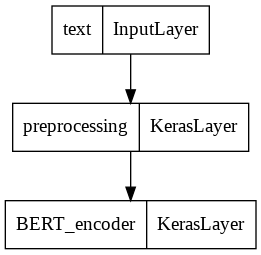

In [ ]:
tf.keras.utils.plot_model(bert_model)

<h1>Spectrograms</h1>

In [ ]:
df4000_balanced = pd.read_csv('/content/gdrive/MyDrive/ai-playground/ra-text-classification-spectrogram/datasets/isot4000-balanced.csv')
df4000_balanced_true = df4000_balanced.loc[df4000_balanced['category'] == 1]
df4000_balanced_true_list = df4000_balanced_true['text'].tolist()

In [ ]:
true_spectrograms_directory = '/content/gdrive/MyDrive/ai-playground/ra-text-classification-spectrogram/spectrograms/bert-isot4000/True'

In [ ]:
for i in range(len(df4000_balanced_true_list)):
  text = [df4000_balanced_true_list[i]]
  vectors = bert_model(tf.constant(text))

  plt.specgram(vectors[0], Fs = 2)
  plt.rcParams['figure.figsize'] = (50,15)
  plt.savefig(f'{true_spectrograms_directory}/{i}.png')


In [ ]:
df4000_balanced_fake = df4000_balanced.loc[df4000_balanced['category'] == 0]
df4000_balanced_fake_list = df4000_balanced_fake['text'].tolist()

In [ ]:
fake_spectrograms_directory = '/content/gdrive/MyDrive/ai-playground/ra-text-classification-spectrogram/spectrograms/bert-isot4000/Fake'

In [ ]:
for i in range(len(df4000_balanced_fake_list)):
  text = [df4000_balanced_fake_list[i]]
  vectors = bert_model(tf.constant(text))

  plt.specgram(vectors[0], Fs = 2)
  plt.rcParams['figure.figsize'] = (50,15)
  plt.savefig(f'{fake_spectrograms_directory}/{i}.png')